**现代卷积神经网络**

@ Date: 2025-04-13<br>
@ Author: Rui Zhu<br>
@ Images From: https://d2l.ai/chapter_convolutional-modern/index.html<br>
@ 概览<br>
1. CNN从LeNet开始
2. AlexNet增加了网络层数, 并使用ReLU, 发现效果更好
3. VGG开始提出块的概念, 方便构造更复杂的网络, 并且发现更深更好
4. NiN使用全局平均汇聚替换全连接层, 减小模型参数, 防止过拟合
5. GoogLeNet引入包含子网络的Inception块
6. ResNet引入残差块, 解决了深度网络训练困难的问题
7. DenseNet进一步扩展ResNet, 通过密集连接来提高特征重用, 引入过度层控制模型复杂度, 
   使得网络更深, 但参数更少

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from astrokit.ML import d2l

dir_data = "/Users/rui/Code/Astronote/32_PyTorch/data/chapter7"

---
# AlexNet
- AlexNet以Alex Krizhevsky的名字命名, 他是文章的第一作者
- AlexNet在2012年横空出世, 首次证明了学习到的特征可以超越手动设计的特征
- AlexNet的为ImageNet数据集设计
- AlexNet VS. LeNet
    1. AlexNet深的多: AlexNet有8个层组成, 其中5个卷积层、2个全连接隐藏层和1个全连接输出层
    2. AlexNet使用ReLU而不是sigmoid作为其激活函数
    3. 更大的卷积窗口: 因为ImageNet中的图像比MNIST图像大10倍以上, 需要用更大的卷积窗口来捕获窗口
    4. 使用ReLU: ReLU的计算更简单; sigmoid函数对输入敏感, ReLU使训练更容易
    5. 使用dropout方法控制全连接层的模型复杂度, 而LeNET只使用了权重衰减
    6. AlexNet在训练时增加了大量的图像增强数据, 如翻转、裁切和变色, 使模型更健壮, 更大的样本量有效地减少了过拟合

In [ ]:
# 使用Fashion-MNIST数据集(原始论文AlexNet使用ImageNet数据集, 但过于庞大, 训练时间过长)
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224, dir_data=dir_data)

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(), 
    nn.MaxPool2d(kernel_size=3, stride=2), 
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), 
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)

train loss: 0.330, train acc: 0.878, test acc: 0.882
364.7 examples/sec on mps


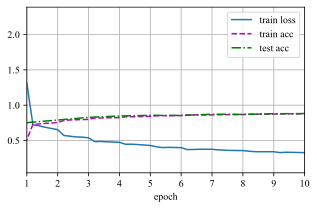

In [4]:
lr, num_epochs = 0.01, 10
d2l.train_net(net, train_iter, test_iter, num_epochs, lr, torch.device('mps'))

---
# VGG
- VGG 是一种 深度卷积神经网络结构, 最早由牛津大学视觉几何组（Visual Geometry Group）提出, 因此得名VGG
- 核心思想: 
    1. 更高层次上抽象层的概念, 称为块(block)
    2. 使用`可复用的卷积块`构造网络, 有效地设计复杂网络
    3. 发现: 深层且窄的卷积(如3x3)比浅层且宽的卷积更有效

In [9]:
def vgg_block(num_convs, in_channels, out_channels):
    """
    实现一个VGG块

    Parameters
    ----------
    num_convs : int
        卷积层的数量
    in_channels : int
        输入通道数
    out_channels : int
        输出通道数
    """
    layers = []
    for _ in range(num_convs):
        layers.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

def vgg(conv_arch):
    """
    定义VGG网络, 即VGG-11
    该网络中有8个卷积层和3个全连接层, 因此称为VGG-11

    Parameters
    ----------
    conv_arch : list
        定义每个VGG块中卷积层个数和输出通道数
    """
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    net = nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(p=0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
        nn.Linear(4096, 10)
    )
    return net

In [10]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
net = vgg(conv_arch)

# 测试网络
X = torch.randn(1, 1, 224, 224)
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [11]:
# 原始VGG-11用于ImageNet数据集, 这里使用Fashion-MNIST数据集, 需要降低模型复杂度
# 降低每个VGG块的输出通道数, 使得模型参数量和计算量更小
ratio = 4
small_conv_arch = [(num_convs, out_channels // ratio) for (num_convs, out_channels) in conv_arch]
print(small_conv_arch)

[(1, 16), (1, 32), (2, 64), (2, 128), (2, 128)]


train loss: 0.177, train acc: 0.934, test acc: 0.918
532.3 examples/sec on mps


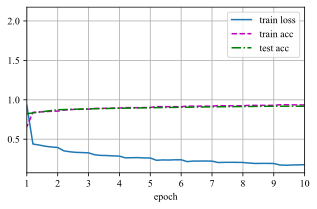

In [12]:
net = vgg(small_conv_arch)
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224, dir_data=dir_data)
d2l.train_net(net, train_iter, test_iter, num_epochs, lr, torch.device('mps'))

---
# NiN
- NiN: Network in Network
- NiN完全取消了全连接层, 显著减少模型的参数数量, 减少过拟合(但并不一定会减少训练时间)
- NiN块: 输出通道数量等于标签类别数
- 全局平均汇聚层(Global average pooling layer): 每个通道的输出将是一个数值，它是这个通道中所有像素的平均值
- NiN结构: (NiN块 + 3x3最大汇聚) * 3 + (NiN块 + 全局平均汇聚层)

In [13]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding), 
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),  # 1x1卷积, 相当于针对像素位置上的全连接层
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),  # 1x1卷积, 相当于针对像素位置上的全连接层
        nn.ReLU(),
    )
    return block

net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0), 
    nn.MaxPool2d(3, stride=2), 
    nin_block(96, 256, kernel_size=5, strides=1, padding=2), 
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2), 
    nn.Dropout(p=0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),  # 自适应平均池化, 自动根据目标输出大小来计算池化参数
    nn.Flatten(),
)

In [14]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


train loss: 0.336, train acc: 0.876, test acc: 0.880
381.8 examples/sec on mps


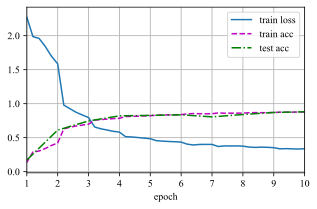

In [15]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224, dir_data=dir_data)
d2l.train_net(net, train_iter, test_iter, num_epochs, lr, torch.device('mps'))

---
# GoogLeNet
- 解决了多大卷积核最合适的问题
- 发现使用不同大小的卷积核组合是有利的
- Inception块: 
1. 架构如图所示, 包含4条并行的路径, 每条路径使用不同大小的卷积核, 使用合适的填充使最终的输出与输入的高度和宽度一致
2. Inception块是有4条路径的子网络
3. Inception块使用1x1卷积层减少通道数, 降低模型复杂度
4. Inception块的通道数分配是通过实验确定的
    <br><img src="figs/inception.png" width="500"/>

- GoogLeNet架构:
1. 使用了9个Inception块
2. Inception块之间的最大汇聚层可降低维度
3. Inception块之前的块结构类似AlexNet和LeNet
4. Inception块组合的设计从VGG继承
5. 最后继承NiN的设计, 在最后使用全局平均汇聚层替代全连接层
    <br><img src="figs/googlenet.png" width="500"/>

In [3]:
class Inception(nn.Module):
    """
    实现Inception块

    Parameters
    ----------
    in_channels : int
        输入通道数
    c1-c4是每条路径的输出通道数
    """
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)  # 调用父类的构造函数
        # 路径1, 单一1x1卷积
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 路径2, 1x1卷积 + 3x3卷积
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 路径3, 1x1卷积 + 5x5卷积
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 路径4, 3x3最大池化 + 1x1卷积
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, X):
        p1 = F.relu(self.p1_1(X))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(X))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(X))))
        p4 = F.relu(self.p4_2(self.p4_1(X)))
        # 拼接四条路径的输出
        return torch.cat((p1, p2, p3, p4), dim=1)

In [4]:
"""
搭建GoogLeNet网络
"""
# b1: 7x7卷积 + 3x3最大池化
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(), 
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# b2: 1x1卷积 + 3x3卷积 + 3x3最大池化
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1), 
                   nn.ReLU(), 
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(), 
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# b3: 2个Inception块 + 3x3最大池化
b3 = nn.Sequential(Inception(192, 64, (128, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# b4: 5个Inception块 + 3x3最大池化
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# b5: 2个Inception块 + 全局平均池化
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)), 
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [5]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


train loss: 0.248, train acc: 0.905, test acc: 0.889
729.1 examples/sec on mps


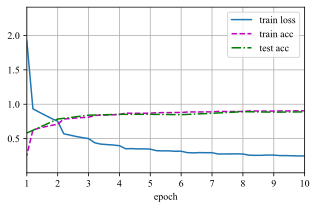

In [6]:
# 224x224的输入很耗时, 因此使用96x96的输入
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96, dir_data=dir_data)
d2l.train_net(net, train_iter, test_iter, num_epochs, lr, torch.device('mps'))

---
# 批量规范化
- 批量规范化(Batch Normalization, BN)是一种流行且有效的技术, 可持续加速深层网络的收敛
- 为什么需要BN?
    1. 数据预处理的方式会对结果产生巨大影响
    2. 神经网络训练时, 中间层的输出变量可能具有更广的变化范围, 阻碍网络的收敛
    3. 深层网络很复杂, 容易过拟合
- BN的原理:
    1. 迭代每个小批量, 首先规范化输入, 即减去其均值并除以其标准差, 然后应用比例系数和比例偏移
    2. 注意: batchsize=1时, 减去均值后隐藏单元为0, BN失效; 只有使用足够大的batchsize时, BN才有效且稳定
    3. 表达式:$$\rm BN(x) = \gamma \odot \frac{x-\hat\mu_B}{\hat\sigma_B} + \beta$$
        其中, $\hat\mu_B$是小批量的均值, $\hat\sigma_B$是小批量的标准差, $\gamma$(拉伸参数, scaleparameter)和$\beta$(偏移参数, shift parameter)是可学习的参数, 使网络具有自由调节的能力
- 事实证明, 但理论上尚未明确证明: 优化中的各种噪声源通常会导致更快的训练和较少的过拟合
- 一些理论证明: BN最适合解决50~100的中等批量大小的问题
- BN在训练模式和预测模式时的表现不同:
    1. 训练模式: 使用小批量的均值和标准差来规范化
    2. 预测模式: 使用整个数据集的均值和标准差来规范化
- 批量规范化层:
    1. 在全连接层上的实现: BN在仿射变换之后, 激活函数之前, 即$h = \phi(\rm BN(Wx+b))$
    2. 在卷积层上的实现: 与全连接层类似, 但在卷积层上, BN对每个通道计算, 每个通道都有自己的拉伸参数和偏移参数
    3. 在预测过程中的BN: 预测过程时一个一个样本输入, 不能使用其均值和方差. 因此使用训练期间累计的“全训练样本的均值和方差”

## 手动实现BN

In [3]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):

    if not torch.is_grad_enabled():  # 判断是否是训练模式
        # 预测模式
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)  # 输入数据必须是2维(全连接层)或4维(卷积层)
        if len(X.shape) == 2:  # 全连接层
            mean = X.mean(dim=0)  # 按列求均值
            var = ((X - mean) ** 2).mean(dim=0)
        else:  # 卷积层
            mean = X.mean(dim=(0, 2, 3), keepdim=True)  # 对batch, 高度, 宽度求均值
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均
        moving_mean = momentum * moving_mean + (1 - momentum) * mean
        moving_var = momentum * moving_var + (1 - momentum) * var

    Y = gamma * X_hat + beta  # 缩放和移动
    
    return Y, moving_mean.data, moving_var.data

In [4]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和更新的参数gamma初始化为1, beta初始化为0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 移动平均的均值和方差分别初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 设备匹配
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 输出
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            eps=1e-5, momentum=0.9
        )
        return Y

In [5]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), BatchNorm(6, num_dims=4), nn.Sigmoid(),   # C1
    nn.AvgPool2d(kernel_size=2, stride=2),  # S2
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),  # C3
    nn.AvgPool2d(kernel_size=2, stride=2),  # S4
    nn.Flatten(),  # 展平
    nn.Linear(16 * 5 * 5, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),  # F5
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),  # F6
    nn.Linear(84, 10)  # 输出层
)

In [6]:
# 测试网络
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
BatchNorm output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
BatchNorm output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
BatchNorm output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
BatchNorm output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


train loss: 0.247, train acc: 0.909, test acc: 0.801
16383.4 examples/sec on mps
Cost Time: 1 min, 22.51 s


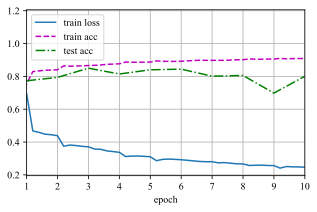

In [7]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(
    batch_size=batch_size, dir_data=dir_data, resize=None)

d2l.train_net(net, train_iter, test_iter, num_epochs, lr, torch.device('mps'))

## 简明实现

In [8]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.BatchNorm2d(6), nn.Sigmoid(),   # C1
    nn.AvgPool2d(kernel_size=2, stride=2),  # S2
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),  # C3
    nn.AvgPool2d(kernel_size=2, stride=2),  # S4
    nn.Flatten(),  # 展平
    nn.Linear(16 * 5 * 5, 120), nn.BatchNorm1d(120), nn.Sigmoid(),  # F5
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),  # F6
    nn.Linear(84, 10)  # 输出层
)

train loss: 0.258, train acc: 0.904, test acc: 0.844
24516.1 examples/sec on mps
Cost Time: 1 min, 8.87 s


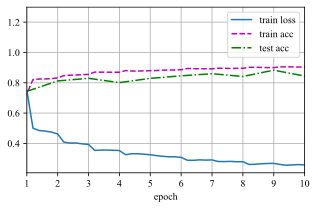

In [9]:
d2l.train_net(net, train_iter, test_iter, num_epochs, lr, torch.device('mps'))

---
# ResNet
- ResNet(Residual Networks, 残差网络)是由微软研究院的何凯明等人提出的一种深度卷积神经网络架构
- 首次出现在2015年的论文《Deep Residual Learning for Image Recognition》中
- ResNet通过引入残差连接, 使非常深的网络训练变得更加容易
- ResNet极大地改变了如何参数化深度网络中函数的观点

## 残差块 (Residual Block)
- 残差块架构, 其中f(x)是理想映射, g(x)=f(x)-x是残差映射
    <br><img src="figs/residual_block.png" height="300"/>
    <img src="figs/resnet_block.png" height="300"/>
- 残差块的设计思想是: 通过引入跳跃连接(skip Connection), 使得网络可以学习到输入和输出之间的残差函数
- 1x1卷积层: 通过1x1卷积层调整通道数, 使得输入和输出的通道数一致

In [4]:
class Residual(nn.Module):
    """
    定义残差块
    """
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, 
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, 
                                   kernel_size=1, stride=strides)
            
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [7]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
print('input shape:\t', X.shape)
print('output shape:\t', Y.shape)

input shape:	 torch.Size([4, 3, 6, 6])
output shape:	 torch.Size([4, 3, 6, 6])


In [9]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
print('input shape:\t', X.shape)
print('output shape:\t', Y.shape)  # 增加了通道数, 也减小了高和宽

input shape:	 torch.Size([4, 3, 6, 6])
output shape:	 torch.Size([4, 6, 3, 3])


## 实现一个ResNet-18架构
<br><img src="figs/resnet.png" height="300"/>

In [11]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), 
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
                    nn.Linear(512, 10))

X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


train loss: 0.012, train acc: 0.997, test acc: 0.912
771.4 examples/sec on mps
Cost Time: 14 min, 19.79 s


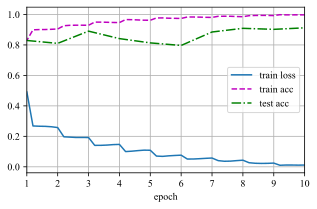

In [12]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(
    batch_size=batch_size, dir_data=dir_data, resize=96)
d2l.train_net(net, train_iter, test_iter, num_epochs, lr, torch.device('mps'))

---
# DenseNet (稠密连接网络)
- 密集连接(dense connectivity): 每一层的输入不仅来自前一层, 还来自所有前面的层
- 密集连接的目的:
    1. 使每一层能够获得前面所有层的信息, 避免信息丢失
    2. 缓解梯度消失问题, 促进特征复用
    3. 相比传统的深层网络, DenseNet具有更少的参数
- DenseNet主要由两部分构成: 稠密块(dense block)和过渡层(transition layer)
- 稠密块: 由多个卷积层组成, 每个卷积层的输入是前面所有卷积层的输出
- 过度层: 用于减小模型复杂度. 由1x1卷积层来减小通道数, 使用步幅为2的平均汇聚层来减小高和宽
- 增长率(growth rate): 卷积块的通道数, 其控制了输出通道数相对于输入通道数的增长程度.
- 架构图:
    <br><img src="figs/densenet.png" height="200"/>

In [4]:
def conv_block(input_channels, num_channels):
    """定义卷积块"""
    net = nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1)
    )
    return net

class DenseBlock(nn.Module):
    """
    定义稠密块
    """
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(
                conv_block(num_channels * i + input_channels, num_channels)
            )
        self.net = nn.Sequential(*layer)
    
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return X


# 测试
blk = DenseBlock(num_convs=2, input_channels=3, num_channels=10)
X = torch.rand(size=(4, 3, 8, 8))
Y = blk(X)
print('input shape:\t', X.shape)
print('output shape:\t', Y.shape)

input shape:	 torch.Size([4, 3, 8, 8])
output shape:	 torch.Size([4, 23, 8, 8])


In [9]:
def transition_block(input_channels, num_channels):
    net = nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(), 
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )
    return net

# 测试
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

In [11]:
# 定义DenseNet
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), 
    nn.BatchNorm2d(64), nn.ReLU(), 
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

num_channels = 64  # 每个稠密块的输出通道数
growth_rate = 32  # 每个卷积层的输出通道数
num_convs_in_dense_blocks = [4, 4, 4, 4]  # 每个稠密块中的卷积层数

blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    num_channels += num_convs * growth_rate
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels //= 2

net = nn.Sequential(
    b1, *blks, 
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
    nn.Linear(num_channels, 10)
)

# 测试
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
DenseBlock output shape:	 torch.Size([1, 192, 24, 24])
Sequential output shape:	 torch.Size([1, 96, 12, 12])
DenseBlock output shape:	 torch.Size([1, 224, 12, 12])
Sequential output shape:	 torch.Size([1, 112, 6, 6])
DenseBlock output shape:	 torch.Size([1, 240, 6, 6])
Sequential output shape:	 torch.Size([1, 120, 3, 3])
DenseBlock output shape:	 torch.Size([1, 248, 3, 3])
BatchNorm2d output shape:	 torch.Size([1, 248, 3, 3])
ReLU output shape:	 torch.Size([1, 248, 3, 3])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 248, 1, 1])
Flatten output shape:	 torch.Size([1, 248])
Linear output shape:	 torch.Size([1, 10])


train loss: 0.143, train acc: 0.948, test acc: 0.889
712.4 examples/sec on mps
Cost Time: 15 min, 19.00 s


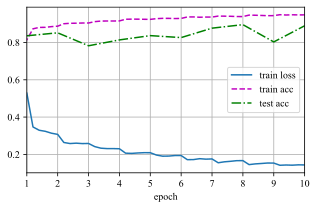

In [12]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(
    batch_size=batch_size, dir_data=dir_data, resize=96)
d2l.train_net(net, train_iter, test_iter, num_epochs, lr, torch.device('mps'))